### 1. Data Pre-processing

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
working_direc = '/content/drive/MyDrive/Data_Science/Projects/Computer_Vision/Human-Emotion-Detection/'
train_direc = working_direc +'Emotions Dataset/train'
val_direc = working_direc +'Emotions Dataset/test'
CLASS_NAMES = ["angry", "happy", "sad"]

CONFIGURATIONS = {
    'BATCH_SIZE':32,
    'IM_SIZE': 256,
    'LEARNING_RATE': 0.001,
    'N_EPOCH': 20,
    'DROPOUT_RATE':0.0,
    'REGULARIZTION_RATE': 0.0,
    'N_FILTERS':6,
    'KERNEL_SIZE':3,
    'N_STRIDES':1,
    'POOL_SIZE':2,
    'N_DENSE_1': 100,
    'N_DENSE_2': 10,
    'NUM_CLASSES':3
}

In [38]:
import tensorflow as tf

In [39]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_direc,
    labels = 'inferred',
    label_mode ='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size =CONFIGURATIONS['BATCH_SIZE'],
    image_size =(CONFIGURATIONS['IM_SIZE'], CONFIGURATIONS['IM_SIZE']),
    shuffle = True,
    seed =99
)

Found 6799 files belonging to 3 classes.


In [40]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_direc,
    labels = 'inferred',
    label_mode ='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size =CONFIGURATIONS['BATCH_SIZE'],
    image_size =(CONFIGURATIONS['IM_SIZE'], CONFIGURATIONS['IM_SIZE']),
    shuffle = True,
    seed =99
)

Found 2278 files belonging to 3 classes.


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

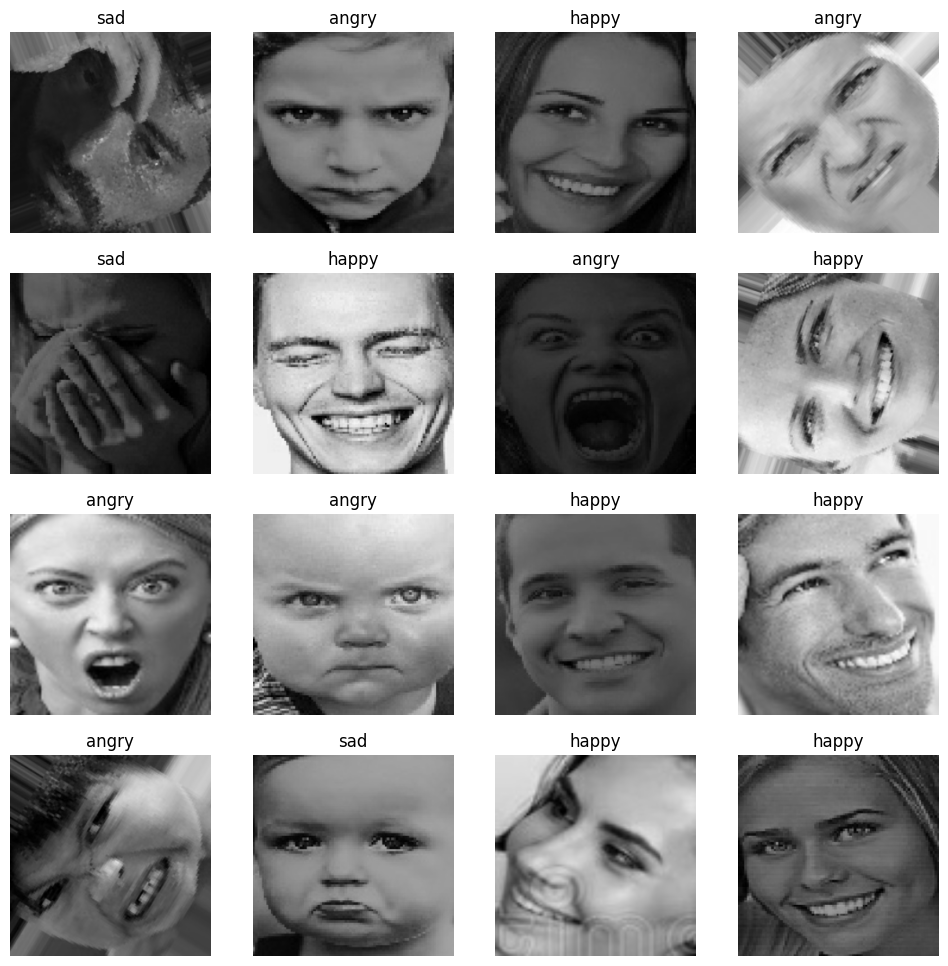

In [42]:
plt.figure(figsize =(12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.0)
    plt.title(CLASS_NAMES[tf.argmax(labels.numpy()[i])])
    plt.axis('off')

In [43]:
# Data Augmentation

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast

augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
    ]
)

def augment_layer(image, label):
  return augment_layers(image, training=True), label

In [44]:
training_dataset = (train_dataset
                    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
                    .prefetch(tf.data.AUTOTUNE))
validation_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [45]:
from tensorflow.keras.layers import Rescaling, Resizing

resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATIONS['IM_SIZE'], CONFIGURATIONS['IM_SIZE']),
    Rescaling(1.0/255.0)
])

### 2. Modeling

In [46]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.regularizers import L1, L2

In [47]:
LeNet_Model = tf.keras.Sequential([

    InputLayer(input_shape = (None, None, 3)),
    resize_rescale_layers,

    Conv2D(filters =CONFIGURATIONS['N_FILTERS'], kernel_size = CONFIGURATIONS['KERNEL_SIZE'], strides =CONFIGURATIONS['N_STRIDES'],
           padding='valid', activation ='relu', kernel_regularizer = L2(CONFIGURATIONS['REGULARIZTION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size =CONFIGURATIONS['POOL_SIZE'], strides =CONFIGURATIONS['N_STRIDES']*2),
    Dropout(rate = CONFIGURATIONS['DROPOUT_RATE']),

    Conv2D(filters =CONFIGURATIONS['N_FILTERS']*2 + 4, kernel_size=CONFIGURATIONS['KERNEL_SIZE'], strides =CONFIGURATIONS['N_STRIDES'],
           padding = 'valid', activation ='relu', kernel_regularizer = L2(CONFIGURATIONS['REGULARIZTION_RATE'])),
    BatchNormalization(),
    MaxPool2D(pool_size =CONFIGURATIONS['POOL_SIZE'], strides =CONFIGURATIONS['N_STRIDES']*2),
    Dropout(rate = CONFIGURATIONS['DROPOUT_RATE']),

    Flatten(),
    Dense(CONFIGURATIONS['N_DENSE_1'], activation='relu', kernel_regularizer = L2(CONFIGURATIONS['REGULARIZTION_RATE'])),
    BatchNormalization(),
    Dense(CONFIGURATIONS['N_DENSE_2'], activation='relu', kernel_regularizer = L2(CONFIGURATIONS['REGULARIZTION_RATE'])),
    BatchNormalization(),
    Dense(CONFIGURATIONS['NUM_CLASSES'], activation='softmax')
])

In [48]:
LeNet_Model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

### 3. Training and Optimization

In [49]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall, F1Score, AUC, CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau

In [50]:
METRICS = [Precision(name ='precision'), Recall(name ='recall'), AUC(name ='auc'), CategoricalAccuracy(name ='accuracy'),
           TopKCategoricalAccuracy(k=2, name ='topk_accuracy')]

loss_function = CategoricalCrossentropy()

In [51]:
LeNet_Model.compile(optimizer=Adam(learning_rate=CONFIGURATIONS['LEARNING_RATE']), loss=loss_function, metrics = METRICS)

In [52]:
# csv logger
path = working_direc + 'LeNet_model_logs.csv'
csv_callback = CSVLogger(path, separator = ',', append = True)

# tensorboard callback
import datetime
current_time = datetime.datetime.now().strftime('%d%m%y - %h%m%s')

metrics_path = './logs/' + current_time + '/metrics/'
METRIC_DIR = working_direc + metrics_path
train_writer = tf.summary.create_file_writer(METRIC_DIR)

log_filepath = working_direc + './logs/' + current_time
LOG_DIR = working_direc + './logs/' + current_time
tensorboard_Callback = tf.keras.callbacks.TensorBoard(log_dir = LOG_DIR)

# early stopping
es_callback = EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto',
    restore_best_weights = True
)


# learning rate scheduling
def scheduler(epoch, lr):

  if epoch <= 10:
    learning_rate = lr
  else:
    learning_rate = lr * tf.math.exp(-0.1)
    learning_rate = learning_rate.numpy()

  with train_writer.as_default():
    tf.summary.scalar('Learning Rate', data = learning_rate, step = epoch)
  return learning_rate
scheduler_callback = LearningRateScheduler(scheduler, verbose = 1)

# reduce learning rate on plateau
plateau_callback = ReduceLROnPlateau(
    monitor = 'val_accuracy', factor =0.1, patience =3, verbose =1
)

# model checkpointing
location = working_direc + '/model_checkpoint/'
checkpoint_callback = ModelCheckpoint(
    location,
    monitor = 'val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode ='auto',
    save_freq='epoch'
)

In [60]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '/device:GPU:0'

In [61]:
model_training = LeNet_Model.fit(training_dataset, validation_data=validation_dataset, epochs=CONFIGURATIONS['N_EPOCH'], verbose=1
                               ,callbacks=[tensorboard_Callback, csv_callback, es_callback, scheduler_callback, checkpoint_callback, plateau_callback])


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
212/213 [============================>.] - ETA: 0s - loss: 0.6843 - precision: 0.7608 - recall: 0.6246 - auc: 0.8725 - accuracy: 0.7017 - topk_accuracy: 0.9049
Epoch 1: val_loss improved from inf to 0.75589, saving model to /content/drive/MyDrive/Data_Science/Projects/Computer_Vision/Human-Emotion-Detection//model_checkpoint/
213/213 [==============================] - 230s 1s/step - loss: 0.6841 - precision: 0.7609 - recall: 0.6249 - auc: 0.8725 - accuracy: 0.7019 - topk_accuracy: 0.9048 - val_loss: 0.7559 - val_precision: 0.7283 - val_recall: 0.5896 - val_auc: 0.8438 - val_accuracy: 0.6646 - val_topk_accuracy: 0.8793 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
212/213 [============================>.] - ETA: 0s - loss: 0.6367 - precision: 0.7838 - recall: 0.6611 - auc: 0.8908 - accuracy: 0.7295 - topk_accuracy: 0.9180
Epoch 2: val_loss d

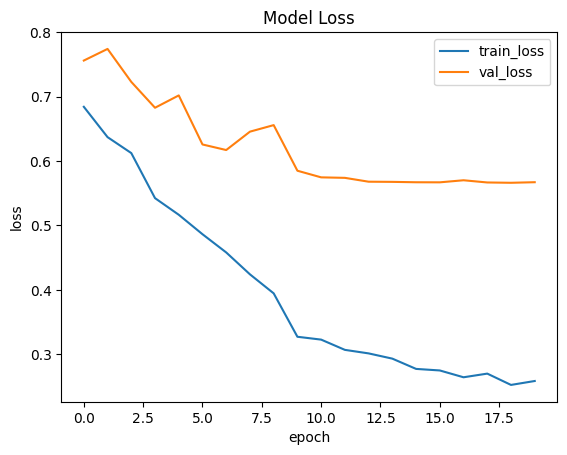

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Model Loss')
plt.legend(['train_loss', 'val_loss'])

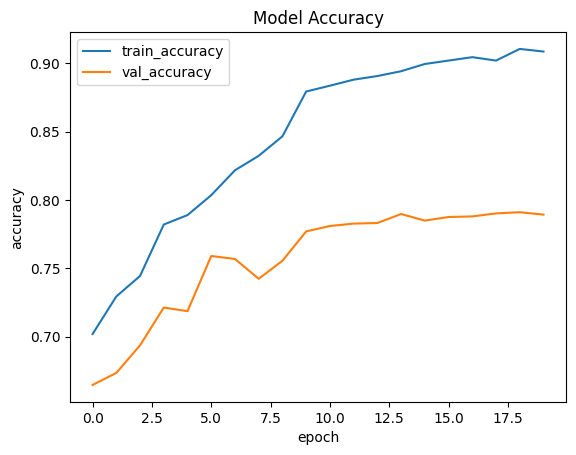

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(model_training.history['accuracy'])
plt.plot(model_training.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Model Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])

### 4. Evaluation and Testing

In [64]:
LeNet_Model.evaluate(validation_dataset)

72/72 [==============================] - 8s 96ms/step - loss: 0.5671 - precision: 0.8102 - recall: 0.7665 - auc: 0.9238 - accuracy: 0.7893 - topk_accuracy: 0.9320


[0.5671173334121704,
 0.810208797454834,
 0.7664617896080017,
 0.923751175403595,
 0.7892888784408569,
 0.9319578409194946]

In [82]:
CLASS_NAMES[tf.argmax(LeNet_Model(tf.expand_dims(images[0], axis =0)), axis =1).numpy()[0]]

'sad'

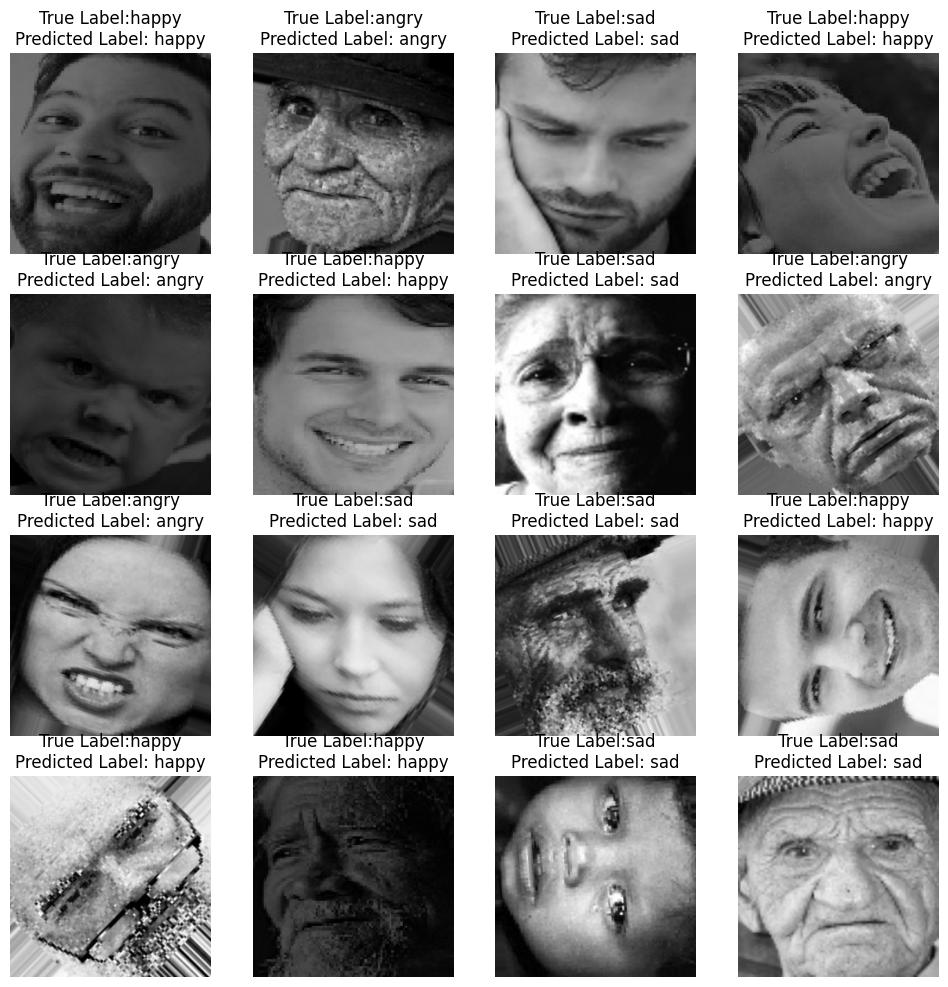

In [87]:
plt.figure(figsize =(12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.0)
    plt.title('True Label:' + CLASS_NAMES[tf.argmax(labels.numpy()[i])] + '\n' +
              'Predicted Label: ' + CLASS_NAMES[tf.argmax(LeNet_Model(tf.expand_dims(images[i], axis =0)), axis =-1).numpy()[0]])
    plt.axis('off')

#### Metrics

In [88]:
import numpy as np
predictions = []
labels = []

for im, label in validation_dataset:
  predictions.append(LeNet_Model(im))
  labels.append(label.numpy())

preds = np.concatenate([np.argmax(predictions[:-1], axis = -1).flatten(), np.argmax(predictions[-1], axis = -1).flatten()])
true_labels = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(predictions[-1], axis = -1).flatten()])

[[349  63 104]
 [ 38 862 105]
 [ 78  90 589]]


Text(0.5, 14.722222222222216, 'Predicted')

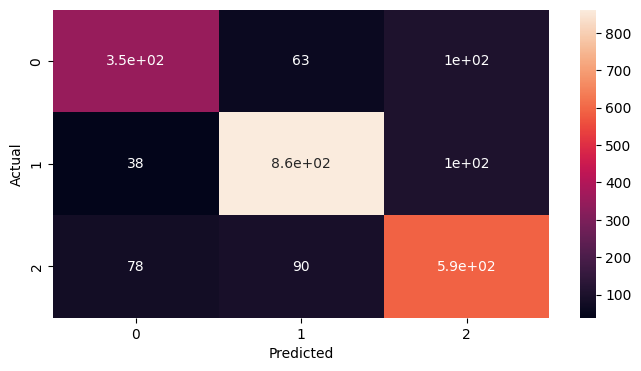

In [94]:
# confusion matrix
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

conf = confusion_matrix(true_labels, preds)

print(conf)

plt.figure(figsize = (8,4))
sns.heatmap(conf, annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [98]:
f1_score(true_labels, preds, average='micro')

0.7901668129938543

In [66]:
save_model_path = working_direc + 'LeNet_Model_seq.keras'
LeNet_Model.save(save_model_path)

In [ ]:
# from tensorflow.train import BytesList, FloatList, Int64List, Example, Feature, Features